In [3]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations

# Add parent directory to path.
from pathlib import Path
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
fdir = Path(os.path.abspath('')).resolve() # Directory of current file.
path = fdir/'..'
if path not in sys.path:
    sys.path.append(str(path))

# Complete imports.
import datetime as dt
from functools import partial
import makassar_ml as ml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import seaborn as sns
from sklearn.model_selection import ParameterGrid
sns.set() # Use seaborn themes.

# List all GPUs visible to TensorFlow.
gpus = tf.config.list_physical_devices('GPU')
print(f"Num GPUs Available: {len(gpus)}")
for gpu in gpus:
    print(f"Name: {gpu.name}, Type: {gpu.device_type}")

Num GPUs Available: 1
Name: /physical_device:GPU:0, Type: GPU


In [4]:
keras.backend.clear_session()

In [5]:
# Configure root paths.
config_roots = dict(
    hp_tuning_root=Path('~/research/makassar/hp_tuning').expanduser(),
)

In [6]:
epochs = 30
batch_size = 256

In [7]:
# Load the dataset.
dataset_kwargs = dict(
    timeseries_path=str(Path('~/research/makassar/datasets/beijing_pm25').expanduser()),
    timeseries_datetime_column='datetime',
    timeseries_features_in=['TEMP','DEWP','PRES','Iws'],
    # timeseries_timedelta_dict_in=dict(hours=24),
    timeseries_seq_len_in=24,
    timeseries_features_out=['pm2.5','Ir'],
    # timeseries_timedelta_dict_out=dict(hours=1),
    timeseries_seq_len_out=1,
    timeseries_reserve_offset_index_in=24,
    timeseries_reserve_offset_index_out=1,
    image_shape=[72,72,3],
    split=['train[0%:70%]', 'train[70%:90%]', 'train[90%:]'],
    shuffle_files=False,
)
dataset_train, dataset_val, dataset_test = ml.datasets.fused_plant_village_beijingpm25_multitask.load_data(
    **dataset_kwargs,
    batch_size=batch_size,
)
n_batches = tf.data.experimental.cardinality(dataset_train)
n_steps = n_batches*epochs

In [8]:
for i,((b_image, b_ts_in), (b_label, b_ts_out)) in enumerate(dataset_train):
    print(f"{b_image.shape=}")
    print(f"{b_ts_in.shape=}")
    print(f"{b_ts_out.shape=}")
    print(f"{b_label.shape=}")
    break

for i,((b_image, b_ts_in), (b_label, b_ts_out)) in enumerate(dataset_val):
    print(f"{b_image.shape=}")
    print(f"{b_ts_in.shape=}")
    print(f"{b_ts_out.shape=}")
    print(f"{b_label.shape=}")
    break

for i,((b_image, b_ts_in), (b_label, b_ts_out)) in enumerate(dataset_test):
    print(f"{b_image.shape=}")
    print(f"{b_ts_in.shape=}")
    print(f"{b_ts_out.shape=}")
    print(f"{b_label.shape=}")
    break

b_image.shape=TensorShape([256, 72, 72, 3])
b_ts_in.shape=TensorShape([256, 24, 4])
b_ts_out.shape=TensorShape([256, 1, 2])
b_label.shape=TensorShape([256])
b_image.shape=TensorShape([256, 72, 72, 3])
b_ts_in.shape=TensorShape([256, 24, 4])
b_ts_out.shape=TensorShape([256, 1, 2])
b_label.shape=TensorShape([256])
b_image.shape=TensorShape([256, 72, 72, 3])
b_ts_in.shape=TensorShape([256, 24, 4])
b_ts_out.shape=TensorShape([256, 1, 2])
b_label.shape=TensorShape([256])


In [9]:
print(f"{epochs=}")
print(f"{n_batches=}")
print(f"{n_steps=}")

epochs=30
n_batches=<tf.Tensor: shape=(), dtype=int64, numpy=149>
n_steps=<tf.Tensor: shape=(), dtype=int64, numpy=4470>


In [10]:
# Build and compile the model.
model = ml.models.FuT_image_timeseries_multitask(
    image_shape=dataset_kwargs['image_shape'],
    in_seq_shape=(dataset_kwargs['timeseries_reserve_offset_index_in'],len(dataset_kwargs['timeseries_features_in'])),
    out_seq_shape=(dataset_kwargs['timeseries_reserve_offset_index_out'],len(dataset_kwargs['timeseries_features_out'])),
    n_class=38,
    patch_size=6,
    image_embed_dim=16,
    seq_embed_dim=5,
    fusion_embed_dim=10,
    n_heads=8,
    ff_dim=256,
    dropout=0.1,
    n_encoders=3,
    fc_units=[],
)
# optimizer = keras.optimizers.Adam(learning_rate=1e-3)
# optimizer = keras.optimizers.Adam(
#     keras.experimental.CosineDecayRestarts(
#         initial_learning_rate=1e-3,
#         first_decay_steps=1000,
#         )
# )
learning_rate = keras.experimental.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=n_steps.numpy(),
    alpha=0.1,
)
# learning_rate = keras.experimental.CosineDecayRestarts(
#     initial_learning_rate=1e-3,
#     first_decay_steps=n_steps//3,
#     m_mul=0.8,
# )
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
metrics = {
    'classifier': 'accuracy',
    'regressor': ['mae','mape'],
}
loss = {
    'classifier': 'sparse_categorical_crossentropy',
    'regressor': 'mse',
}
model.compile(
    optimizer=optimizer,
    # loss='mse',
    # loss=['sparse_categorical_crossentropy','mse'],
    loss=loss,
    metrics=metrics,
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 72, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 24, 4)]      0                                            
__________________________________________________________________________________________________
patches (Patches)               (None, 144, 108)     0           input_1[0][0]                    
__________________________________________________________________________________________________
time2_vec (Time2Vec)            (None, 24, 20)       528         input_2[0][0]                    
____________________________________________________________________________________________

(<tf.Tensor: shape=(), dtype=float32, numpy=0.001>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.000100000114>)

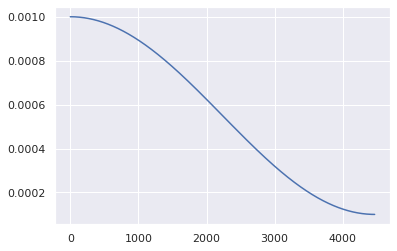

In [11]:
steps = np.arange(n_steps)
lrs = learning_rate(steps)
plt.plot(steps, lrs)
lrs[0],lrs[-1]

In [12]:
model.evaluate(dataset_test.take(1))

1/1 [==============================] - 3s 3s/step - loss: 7.3902 - classifier_loss: 5.3751 - regressor_loss: 2.0151 - classifier_accuracy: 0.0039 - regressor_mae: 0.9709 - regressor_mape: 511.9072


[7.390180587768555,
 5.3751301765441895,
 2.0150504112243652,
 0.00390625,
 0.970868706703186,
 511.9072265625]

In [14]:
# Train.
history = model.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=epochs,
    verbose=1,
)

Epoch 1/30
149/149 [==============================] - 200s 1s/step - loss: 3.2965 - classifier_loss: 2.3344 - regressor_loss: 0.9621 - classifier_accuracy: 0.3746 - regressor_mae: 0.5503 - regressor_mape: 242.0243 - val_loss: 2.2455 - val_classifier_loss: 1.5244 - val_regressor_loss: 0.7210 - val_classifier_accuracy: 0.5639 - val_regressor_mae: 0.4519 - val_regressor_mape: 196.0481
Epoch 2/30
149/149 [==============================] - 16s 105ms/step - loss: 2.0969 - classifier_loss: 1.3008 - regressor_loss: 0.7961 - classifier_accuracy: 0.6192 - regressor_mae: 0.4754 - regressor_mape: 208.5391 - val_loss: 1.8339 - val_classifier_loss: 1.1774 - val_regressor_loss: 0.6566 - val_classifier_accuracy: 0.6486 - val_regressor_mae: 0.4520 - val_regressor_mape: 206.7017
Epoch 3/30
149/149 [==============================] - 16s 105ms/step - loss: 1.7246 - classifier_loss: 0.9985 - regressor_loss: 0.7262 - classifier_accuracy: 0.7018 - regressor_mae: 0.4523 - regressor_mape: 198.3236 - val_loss: 

In [15]:
history.history.keys()

dict_keys(['loss', 'classifier_loss', 'regressor_loss', 'classifier_accuracy', 'regressor_mae', 'regressor_mape', 'val_loss', 'val_classifier_loss', 'val_regressor_loss', 'val_classifier_accuracy', 'val_regressor_mae', 'val_regressor_mape'])

/tmp/ipykernel_25552/2665343523.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


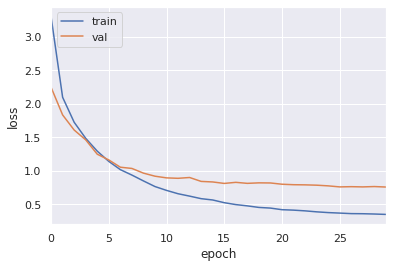

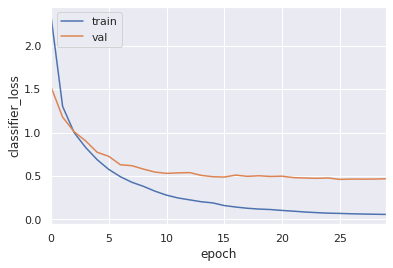

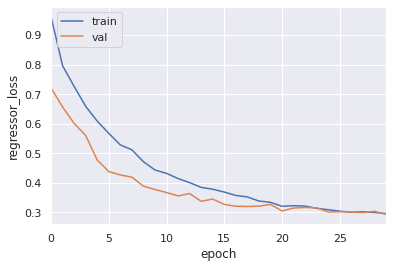

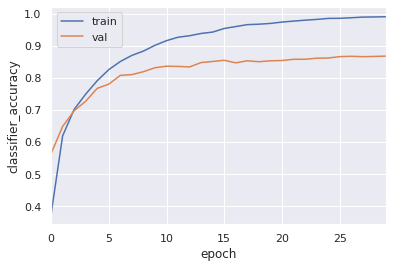

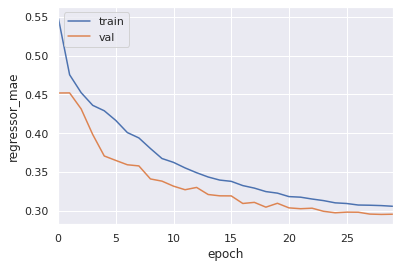

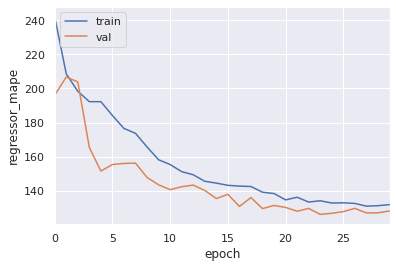

In [17]:
raw_keys = [key for key in history.history.keys() if not key.startswith('val_')]
for key in raw_keys:
    fig = ml.visualization.plot_metric(history.history, key)
    fig.show()